### Stroke Classification Project

The goal of this notebook is to accurately predict a patient's likelihood of having a stroke using a number of features related to their health and lifestyle. This notebook uses data collected from https://www.kaggle.com/fedesoriano/stroke-prediction-dataset.

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Clean and prepare dataframe for EDA

In [243]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke_original = stroke
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [239]:
stroke.drop('id',axis=1,inplace=True)
stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [240]:
#setup numerical values of 1,0 for categorical variables
stroke['ever_married'] = stroke['ever_married'].map({'Yes':1, 'No':0})
stroke['Residence_type'] = stroke['Residence_type'].map({'Urban':1, 'Rural':0})

In [241]:
stroke.isnull().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

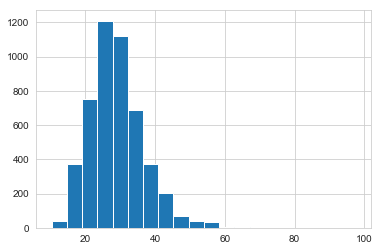

(28.1, 28.893236911794673)

In [242]:
#check to see the distribution of BMI before filling values 
plt.hist(stroke['bmi'],bins= 20)
plt.show()
stroke['bmi'].median(),stroke['bmi'].mean()

In [156]:
#create dummy variables for our multivariable categorical columns
gender_temp = pd.get_dummies(stroke['gender'])
gender_counts = stroke.gender.value_counts()
stroke = pd.concat([stroke,gender_temp],axis=1)
stroke.drop('gender',axis=1,inplace=True)

temp = pd.get_dummies(stroke['work_type'])
work_type_counts = stroke.work_type.value_counts()
stroke = pd.concat([stroke,temp],axis=1)
stroke.drop('work_type',axis=1,inplace=True)

temp = pd.get_dummies(stroke['smoking_status'])
smoking_status_counts = stroke.smoking_status.value_counts()
stroke = pd.concat([stroke,temp],axis=1)
stroke.drop('smoking_status',axis=1,inplace=True)

In [157]:
stroke.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,0,202.21,NaN,1,1,0,0,0,0,0,1,0,0,0,1,0
2,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,0,1,0,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.4,1,1,0,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.0,1,1,0,0,0,0,0,1,0,0,0,1,0


In [158]:
from sklearn.impute import SimpleImputer
#impute the empty values of bmi with the median as it better represents the population
imputer = SimpleImputer(strategy='median')
col = stroke.columns
stroke = imputer.fit_transform(stroke)
stroke = pd.DataFrame(stroke,columns=col)

In [159]:
stroke.isnull().any()

age                  False
hypertension         False
heart_disease        False
ever_married         False
Residence_type       False
avg_glucose_level    False
bmi                  False
stroke               False
Female               False
Male                 False
Other                False
Govt_job             False
Never_worked         False
Private              False
Self-employed        False
children             False
Unknown              False
formerly smoked      False
never smoked         False
smokes               False
dtype: bool

#### EDA 

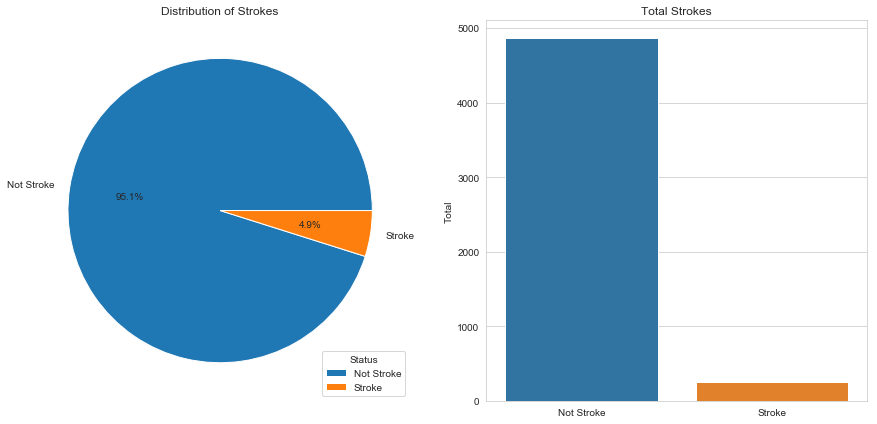

In [160]:

#Examine the class size and distribution of our target variable
sns.set_style('whitegrid')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.pie(x=stroke['stroke'].value_counts(), labels=stroke['stroke'].value_counts().index.map({0:'Not Stroke', 1:'Stroke'}), autopct='%1.1f%%')
ax1.legend(
    title='Status',
    loc = 'lower right')
ax1.set_title('Distribution of Strokes')

plots = sns.barplot(x=stroke['stroke'].value_counts().index.map({0:'Not Stroke', 1:'Stroke'}), y=stroke['stroke'].value_counts(), ax=ax2)

ax2.set_ylabel('Total')
ax2.set_title('Total Strokes')

plt.show()

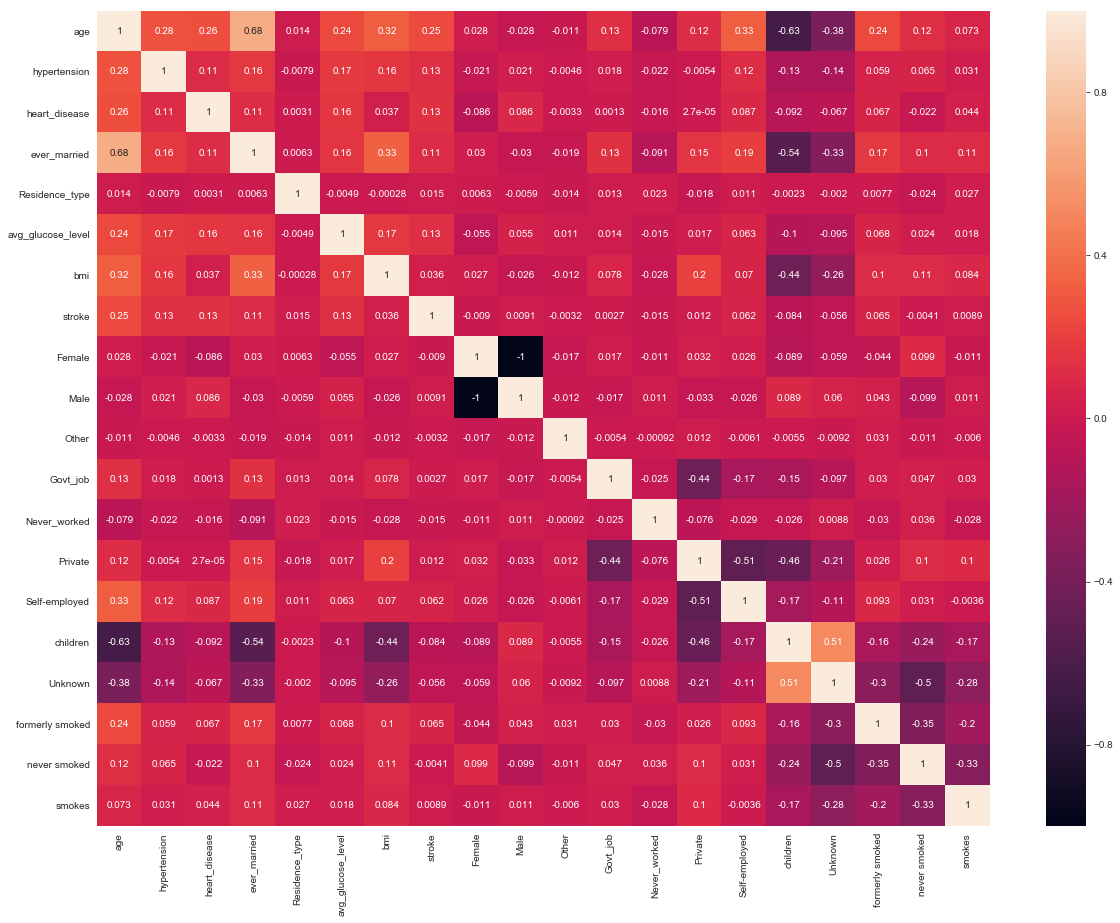

In [161]:
plt.figure(figsize=(20,15))
sns.heatmap(stroke.corr(),annot=True)
plt.show()

> Using a correlation heatmap to explore the correlation that exists between features. Strong correlation between some of variables most notably 'Age' and 'Ever Married' which is to be expected but not correlated strongly enough for us to remove one of the variables. In addition a stroke is correlated with 'age', 'hypertension', 'heart disease' and 'average glucose level'.

In [162]:
def plotting_function(x,y,data=stroke,plot_type='bar'):
    plt.figure(figsize=(10,5))
    if plot_type == 'bar':
        sns.barplot(x=x,y=y,data=data)
        plt.show()
    elif plot_type =='scatter': 
        sns.scatterplot(x=x,y=y, data=data,alpha=.5)
        plt.show()
    

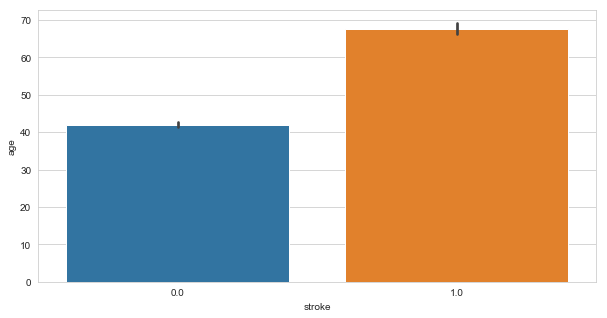

In [163]:
plotting_function(x='stroke',y='age')

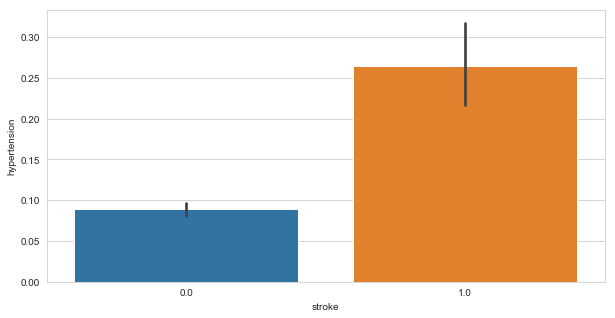

In [164]:
plotting_function(x='stroke',y='hypertension')

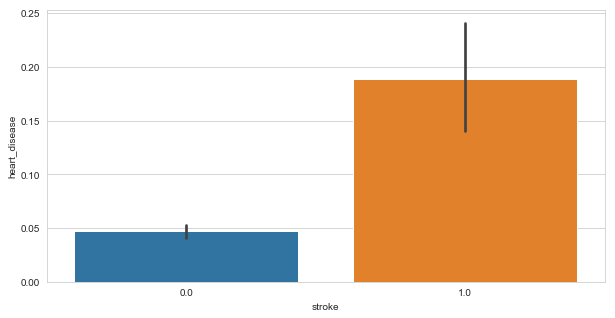

In [165]:
plotting_function(x='stroke',y='heart_disease')

> After examining the percentage of people in our two cohorts (No Stroke vs. Stroke) with hypertension, heart disease and their average age it is clear that these features will be strong predictors for our model and will be important to include. 

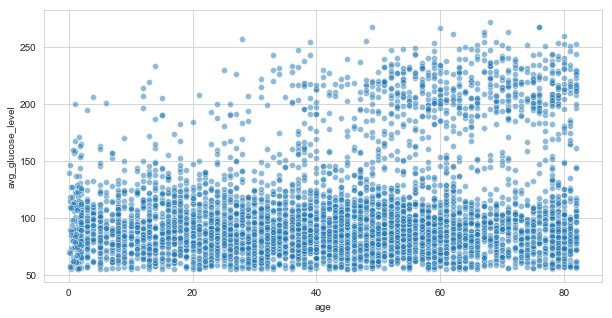

In [166]:
plotting_function(x='age',y='avg_glucose_level', plot_type='scatter')

Text(0.5, 1.0, 'Age of Married vs. Not Married')

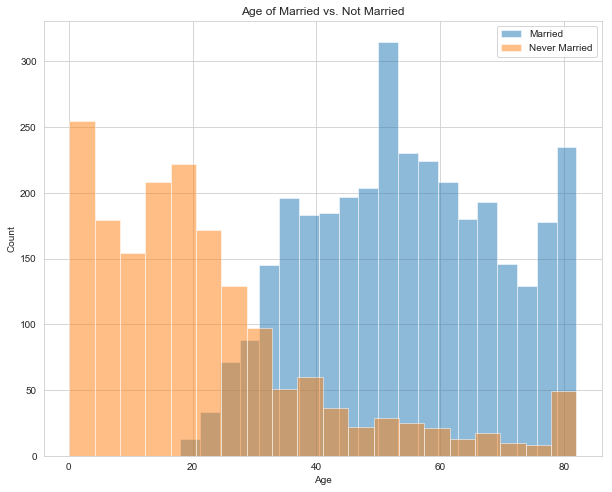

In [167]:
#create two dataframes for married vs. not married
married = stroke[stroke['ever_married'] == 1]
not_married = stroke[stroke['ever_married'] == 0]
#create histogram for ages of individuals married vs. not married to see if its worth including both variables as features
plt.figure(figsize=(10,8))
plt.hist(married['age'], bins=20, alpha=0.5, label="Married")
plt.hist(not_married['age'], bins=20, alpha=0.5, label="Never Married")

plt.xlabel('Age') 
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Age of Married vs. Not Married')

In [278]:
#Get the pct of the population that had a stroke segmented by their occupation status or 'work type'
stroke_worktype_df = stroke_original[['work_type','stroke']]
stroke_worktype_df = stroke_worktype_df.groupby('work_type').stroke.mean().to_frame()
stroke_worktype_df.rename(columns = {'stroke':'Percentage with Stroke'},inplace=True)
#Calculate that same value for the whole population 
stroke_pct_population = len(stroke_original[stroke_original['stroke']==1])/len(stroke_original)

In [295]:
stroke_worktype_df

,Percentage with Stroke
work_type,
Govt_job,0.050228
Never_worked,0.000000
Private,0.050940
Self-employed,0.079365
children,0.002911


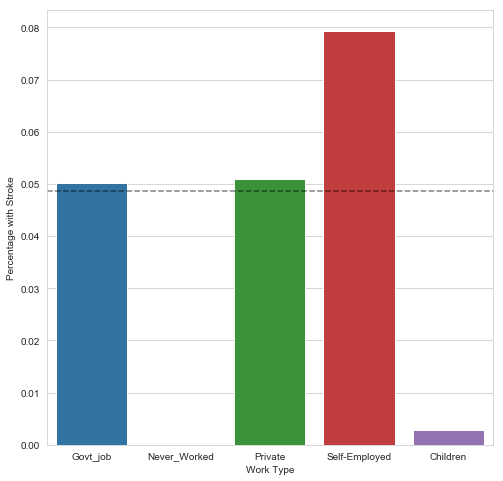

In [293]:
#Plot the above 
plt.figure(figsize=(8,8))
ax = sns.barplot(x=['Govt_job', 'Never_Worked','Private','Self-Employed','Children'],y='Percentage with Stroke',data=stroke_worktype_df)
ax.set(xlabel='Work Type')
ax.axhline(stroke_pct_population,c = 'black',linestyle='dashed',label='Total Population',alpha = 0.5)

> As one of the few lifestyle related features that might directly relate to the quality of healthcare an individual is getting I was interested to see if there was any noticeable splits for the different classes under Work Type and their risk of Stroke. While there is not an overwhelming amount of data to go on there are some differences between the classes of raising Children and Self-Employed when compared to the population average. This could be an interesting hypothesis to explore further, and will be interesting to see if these features show any predictive power in the model.

#### Preprocessing and Modeling

In [20]:
#setup and split our features from our target variable
y = stroke['stroke']
stroke.drop('stroke', axis=1, inplace=True)
X = stroke

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale

In [22]:
X.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,67.0,0.0,1.0,1.0,1.0,228.69,36.6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,61.0,0.0,0.0,1.0,0.0,202.21,28.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0.0,1.0,1.0,0.0,105.92,32.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0.0,0.0,1.0,1.0,171.23,34.4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,79.0,1.0,0.0,1.0,0.0,174.12,24.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [23]:
#For SVM we need all the variables to have zero mean and unit variance so feed features through Standard Scaler
cols = X.columns
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [24]:
X_scaled_df = pd.DataFrame(X_scaled, columns = cols )

In [25]:
X_scaled_df.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,1.051434,-0.328602,4.185032,0.723884,0.984080,2.706375,1.005086,-1.189510,1.189990,-0.01399,-0.384111,-0.065756,0.864297,-0.436881,-0.394112,-0.658011,2.184951,-0.766774,-0.427313
1,0.786070,-0.328602,-0.238947,0.723884,-1.016178,2.121559,-0.098981,0.840682,-0.840343,-0.01399,-0.384111,-0.065756,-1.157010,2.288955,-0.394112,-0.658011,-0.457676,1.304165,-0.427313
2,1.626390,-0.328602,4.185032,0.723884,-1.016178,-0.005028,0.472536,-1.189510,1.189990,-0.01399,-0.384111,-0.065756,0.864297,-0.436881,-0.394112,-0.658011,-0.457676,1.304165,-0.427313
3,0.255342,-0.328602,-0.238947,0.723884,0.984080,1.437358,0.719327,0.840682,-0.840343,-0.01399,-0.384111,-0.065756,0.864297,-0.436881,-0.394112,-0.658011,-0.457676,-0.766774,2.340204
4,1.582163,3.043196,-0.238947,0.723884,-1.016178,1.501184,-0.631531,0.840682,-0.840343,-0.01399,-0.384111,-0.065756,-1.157010,2.288955,-0.394112,-0.658011,-0.457676,1.304165,-0.427313


------

#### SVM Classifier

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled_df,y,test_size=0.20,random_state=70)  

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_curve,roc_auc_score,precision_score

In [28]:
svm_model = SVC(random_state=100,class_weight='balanced')

params = {'C':[0.01,0.1,1,10,100,1000,10000],
          'gamma':[10,1,0.1,0.001,0.0001,0.00001]}

grid_search = GridSearchCV(estimator=svm_model,param_grid=params,verbose=1,n_jobs=-1,scoring='f1')
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   42.9s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=100,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [10, 1, 0.1, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [29]:
svm_model = grid_search.best_estimator_

In [30]:
#the recall and accuracy score on the training set
y_train_pred = svm_model.predict(x_train)
train_f1 = f1_score(y_train,y_train_pred)
train_recall = recall_score(y_train,y_train_pred)
train_accuracy = accuracy_score(y_train,y_train_pred)

In [31]:
#the recall and accuracy on the test set
y_test_pred = svm_model.predict(x_test)
test_f1 = f1_score(y_test,y_test_pred)
test_recall = recall_score(y_test,y_test_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

In [32]:
def plot_model_metrics(f1_train,f1_test,recall_train,recall_test,accuracy_train,accuracy_test,title='Model Metrics'):
    x=[0,1,2,3,4,5]
    y = [f1_train,f1_test,recall_train,recall_test,accuracy_train,accuracy_test]
    plt.figure(figsize=(8,6))
    ax = plt.subplot()
    plt.bar(x=x,height=y,width=.8)
    plt.xticks(rotation=30)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_ylim([0,1])
    ax.set_xticklabels(['f1_train','f1_test','recall_train','recall_test','accuracy_train','accuracy_test'])
    for i, v in enumerate(y):
        ax.text(i-.20,v +.03, str(round(v,3)), color='black', fontweight='bold')
    plt.title(title)
    plt.show()


In [33]:
def plot_roc_auc(fpr,tpr,auc,title): 
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (auc = %0.2f)" % auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

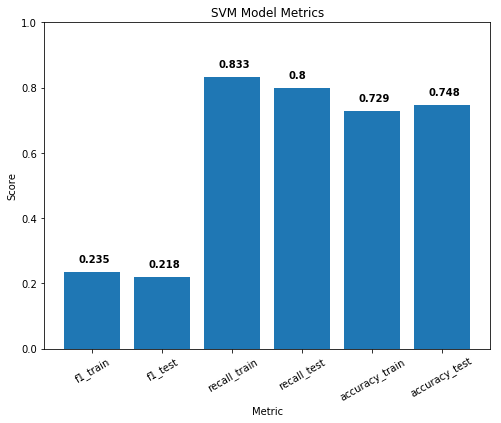

In [34]:
plot_model_metrics(train_f1,test_f1,train_recall,test_recall,train_accuracy,test_accuracy,title='SVM Model Metrics')

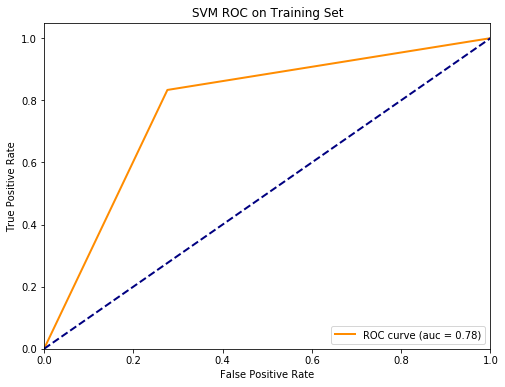

In [35]:
fpr,tpr,thresholds = roc_curve(y_train,y_train_pred)
auc = roc_auc_score(y_train,y_train_pred)
plot_roc_auc(fpr,tpr,auc,title='SVM ROC on Training Set')

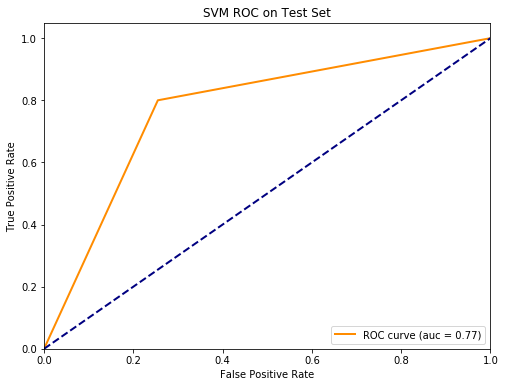

In [36]:
fpr_test,tpr_test,thresholds = roc_curve(y_test,y_test_pred)
auc = roc_auc_score(y_test,y_test_pred)
plot_roc_auc(fpr_test,tpr_test,auc,title='SVM ROC on Test Set')

> This SVM model had better recall than accuracy which would be important for this type of test, and the model generalized well to new samples performing about equal when shown and asked to classify the test set. The AUC of the train and test set are almost identical. Overall this model performed well but not perfect, will try additional classifier models like XGBoost or Random Forest Classifier as well and see how it compares. Unable to explore the most important features contributing to model classification because the SVM Radial kernel was used. 

-------

#### Random Forest Classifier

In [39]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=70)

In [42]:
from sklearn.ensemble import RandomForestClassifier 

In [43]:
Model = RandomForestClassifier(random_state=100,n_jobs=-1,class_weight='balanced')

params = {'n_estimators':[50,100,150],
          'min_samples_leaf':[10,30,50,70,100],
          'max_depth':[3,5,10,20,40,60,100],
          'max_features':[0.2,0.3,0.4,0.5,0.6,0.7],
          'criterion':["gini","entropy"]}

grid_search = GridSearchCV(estimator=Model,param_grid=params,verbose=1,n_jobs=-1,scoring='f1')
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 12.7min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'min_samples_leaf': [10, 30, 50, 70, 100], 'max_depth': [3, 5, 10, 20, 40, 60, 100], 'max_features': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [44]:
rfc_model = grid_search.best_estimator_

In [45]:
y_train_pred = rfc_model.predict(x_train)
train_f1 = f1_score(y_train,y_train_pred)
train_recall = recall_score(y_train,y_train_pred)
train_accuracy = accuracy_score(y_train,y_train_pred)

In [46]:
y_test_pred = rfc_model.predict(x_test)
test_f1 = f1_score(y_test,y_test_pred)
test_recall = recall_score(y_test,y_test_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

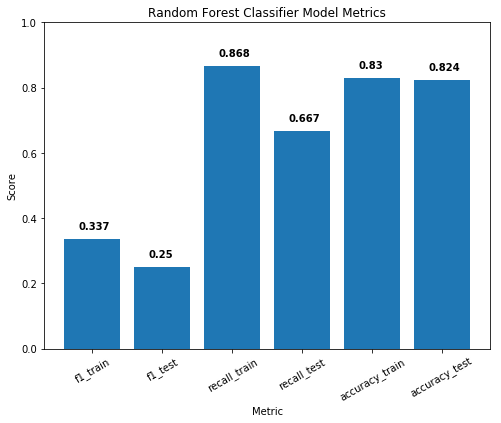

In [47]:
plot_model_metrics(train_f1,test_f1,train_recall,test_recall,train_accuracy,test_accuracy,title='Random Forest Classifier Model Metrics') 

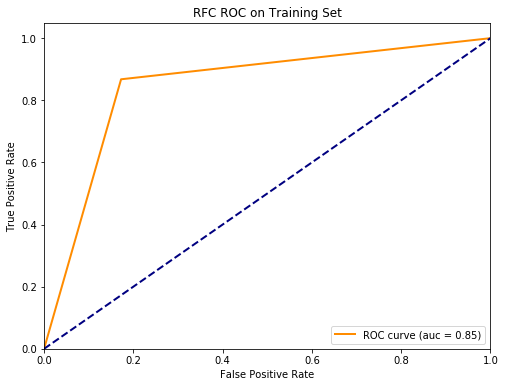

In [48]:
fpr,tpr,thresholds = roc_curve(y_train,y_train_pred)
auc = roc_auc_score(y_train,y_train_pred)
plot_roc_auc(fpr,tpr,auc,title='RFC ROC on Training Set')

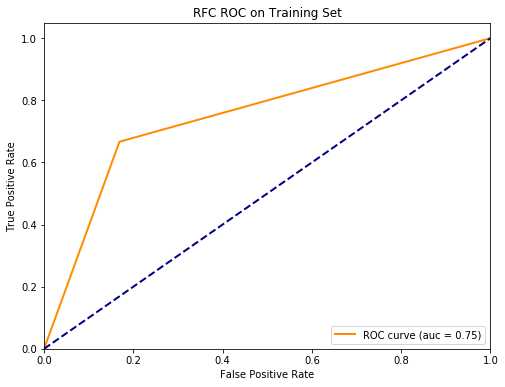

In [49]:
fpr,tpr,thresholds = roc_curve(y_test,y_test_pred)
auc = roc_auc_score(y_test,y_test_pred)
plot_roc_auc(fpr,tpr,auc,title='RFC ROC on Training Set')

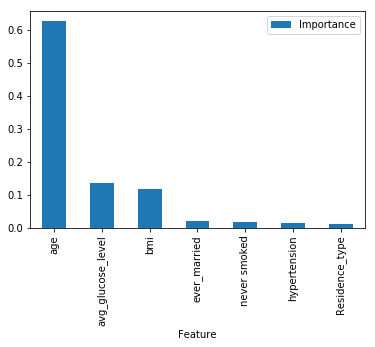

In [58]:
#Take a look at the most importance features for predicting stroke and plot them on a bar graph
def plot_feature_importance(x_train,model):
    feature_importance_df = pd.DataFrame({'Feature':x_train.columns,'Importance':model.feature_importances_})
    feature_importance_df.sort_values(by='Importance',ascending=False,inplace=True)
    feature_importance_df.set_index('Feature',inplace=True)
    top_feat_importance = feature_importance_df[0:7]
    top_feat_importance.plot.bar()
plot_feature_importance(x_train,rfc_model)

> The f1 score for the Random Forest Classifier were better than what we had for the SVM, but the recall score on the set was a fair amount worse. And once again considering the problem we are looking to solve, we want our classifier to be as good as possible at identifying the relevant target samples when generalizing to new data. After looking at the feature importance of the classifier we see some expected results. After EDA and again after model introspection 'age', 'average_glucose_level' and 'bmi' were some of the most important features when separating the patient population based upon the likelihood that they have had a stroke or not. 

-----